In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import jax.numpy as jnp
import jax
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
import seaborn as sns
import pickle
import copy

import src.metrics as metrics
import src.kernels as kernels
import src.bootstrap as boot
import src.exp_utils as exp_utils
import experiments.kef as exp_kef
import experiments.efm as exp_efm

# Exploration

In [72]:
L = 5
params = np.ones((L,))
kef = exp_kef.KernelExpFamily(params=params, bw=np.sqrt(2), L=L, p0_loc=0., p0_scale=1.)

In [19]:
np.random.seed(2024)

X = np.reshape(np.linspace(-5., 5, 1001), (-1,))
lp = [kef.log_unnormalised_density(xx) for xx in X]

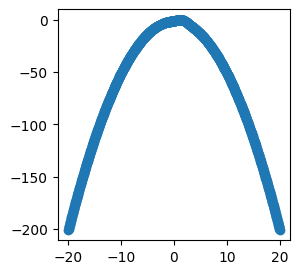

In [20]:
_, ax = plt.subplots(figsize=(3,3))

ax.scatter(X, lp)

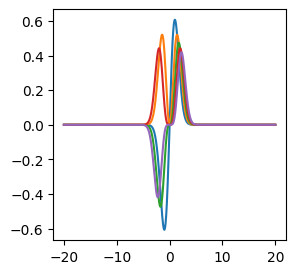

In [38]:
_, ax = plt.subplots(figsize=(3, 3))

phi_vals = np.array([kef.t(x) for x in X])
for l in range(phi_vals.shape[-1]):
    ax.plot(X, phi_vals[:, l])

In [42]:
x = X[400]
jnp.atleast_2d(jax.jacfwd(kef.t)(x))

Array([[-0.00503194,  0.01328365, -0.02848603,  0.0525896 , -0.08623553]],      dtype=float32)

In [57]:
import experiments.efm as exp_efm

efm_model = exp_efm.EFM(np.ones((2,)) * 0.)

x = jnp.array([-.1, .2, 0.3, 0.2, -0.7])
score_approx = jnp.atleast_2d(jax.jacfwd(efm_model.log_unnormalised_density)(x))
print("score_approx", score_approx)

x = jnp.array([[-.1, .2, 0.3, 0.2, -0.7]])
score_exact, _ = efm_model.compute_grad_and_hvp(x)
print("score_exact", score_exact)

JT_approx = jax.jacfwd(efm_model.t)(x)
JT_exact, _, _ = efm_model._compute_grads(x)
print("JT_approx", JT_approx)
print("JT_exact", JT_exact)

score_approx [[ 0.18       -0.26       -0.32000002 -0.22        0.68      ]]
score_exact [[ 0.18       -0.26       -0.32000002 -0.22        0.68      ]]
JT_approx [[[[0.        0.        0.        0.961043  0.       ]]

  [[0.        0.        0.        0.        0.6347395]]]]
JT_exact [[[0.        0.        0.        0.961043  0.       ]
  [0.        0.        0.        0.        0.6347396]]]


In [66]:
x = np.random.normal(size=(100, 5))

JT = jax.vmap(lambda x: jax.jacfwd(efm_model.t)(x))(x)

In [70]:
x = np.random.normal(size=(100, 1))

JT = jax.vmap(lambda x: jax.jacfwd(kef.t)(x))(x)
JT.shape

(100, 5, 1)

# Galaxy data

In [70]:
ys, unnormalize = exp_kef.load_galaxies("../data/kef/galaxies.rda")

# standardise
# ys /= ys.std()

/home/ma/x/xl6116/.envs/robust/lib/python3.8/site-packages/rdata/parser/_parser.py:839: UserWarning: Tag not implemented for type RObjectType.CHAR and ignored
  warnings.warn(
/home/ma/x/xl6116/.envs/robust/lib/python3.8/site-packages/rdata/parser/_parser.py:839: UserWarning: Tag not implemented for type RObjectType.REAL and ignored
  warnings.warn(


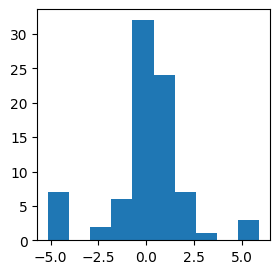

In [71]:
_, ax = plt.subplots(figsize=(3,3))

_ = ax.hist(np.squeeze(ys))

In [207]:
np.random.seed(2024)

level_exp = True

if level_exp:
    add_outliers = True
    eps = 0.
    ol_mean = 10.
    ol_std = .1
    # L = 25
    L = 25 #!
else:
    add_outliers = True
    eps = 0.3
    ol_mean = 1. # 0.
    ol_std = 1. # 1.
    L = 1

split = True

# 1. pure data
X = np.reshape(ys, (-1, 1))

# split
if split:
    n = X.shape[0]
    ntest = int(.5 * n)
    idx = np.random.choice(range(n), size=ntest, replace=False)
    X_test_raw = X[idx]
    X = X[jnp.array([i for i in range(n) if i not in idx])]
else:
    X_test_raw = X

# 2. contam data
if add_outliers:
    X = exp_efm.sample_outlier_contam(X, eps=eps, ol_mean=ol_mean, ol_std=ol_std)

In [208]:
# L = 1 if not add_outliers else 25
# kef_l = jnp.sqrt(2)
# kef_p0_std = 3.0
kef_l = jnp.sqrt(.5) #!
kef_p0_std = 3.0 #!
params = np.ones((L,))
kef = exp_kef.KernelExpFamily(params=params, bw=kef_l, L=L, p0_loc=0., p0_scale=kef_p0_std)

In [209]:
# kernel = kernels.SumKernel([kernels.IMQ(sigma_sq=2*l**2) for l in [0.6, 1.0, 1.2]])
# kernel = kernels.IMQ(med_heuristic=True, X=X, Y=X)
# kernel = kernels.IMQ(sigma_sq=2*1**2, X=X, Y=X)

# poly_weight_fn = kernels.PolyWeightFunction(a=X.std())
poly_weight_fn = kernels.PolyWeightFunction(a=1.)
kernel0 = kernels.IMQ(sigma_sq=2*1.**2, X=X, Y=X)
kernel = kernels.TiltedKernel(kernel=kernel0, weight_fn=poly_weight_fn)

est_params = kef.ksd_est(X, kernel)
print("est_params", est_params)

est_params [-1.847055    0.75088876  1.8829987  -0.80105036  1.2397836  -0.75844806
  0.5964854  -0.5008534   0.05704904 -0.31969798 -0.30043566 -0.2254245
 -0.42621088 -0.19012038 -0.36715445 -0.19946223 -0.22936958 -0.25167274
 -0.11472467 -0.33918083 -0.08226253 -0.44666407 -0.14249243 -0.55801266
 -0.27049342]


In [210]:
trained_kef_model = exp_kef.KernelExpFamily(est_params, bw=kef_l, L=L, p0_loc=0., p0_scale=kef_p0_std)

In [211]:
seed = jax.random.PRNGKey(seed=56789)

X_plot = np.reshape(np.linspace(-10., 10., 1001), (-1, 1))
approx_prob = trained_kef_model.approx_prob(seed, xs=X_plot, n_samples=2000)

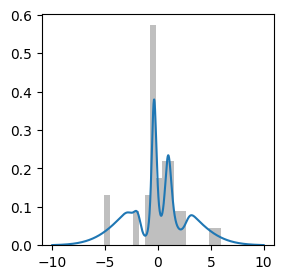

In [212]:
# contam
_, ax = plt.subplots(figsize=(3,3))

# ax.hist(np.squeeze(ys), density=True)
ax.hist(X.reshape(-1), color="grey", alpha=0.5, bins=20, density=True)
ax.plot(X_plot, approx_prob)
# ax.set_xlim(-10., 10.)

#### Test

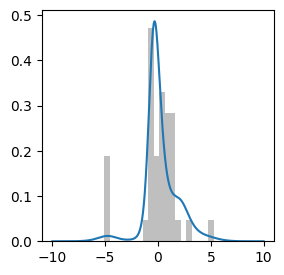

In [169]:
# add_outliers_test = True
# eps = 0.2
# ol_mean = 0.

add_outliers_test = False

if not add_outliers_test:
    X_test = X_test_raw
    
else:
    if add_outliers:
        X_test = exp_efm.sample_outlier_contam(X_test_raw, eps=eps, ol_mean=ol_mean, ol_std=0.1)
    else:
        X_test = X_test_raw
# X_test = X_test[X_test < 7.].reshape((-1, 1))

score = jax.vmap(trained_kef_model.score)(X_test)

_, ax = plt.subplots(figsize=(3,3))
ax.hist(X_test.reshape(-1), color="grey", alpha=0.5, bins=20, density=True)
ax.plot(X_plot, approx_prob)

In [170]:
# # np.random.seed(321)

# # test_kernel = kernel
# # test_kernel = kernels.IMQ(sigma_sq=2*1**2, X=X, Y=X)

# # poly_weight_fn = kernels.PolyWeightFunction(a=X.std())
# poly_weight_fn = kernels.PolyWeightFunction(a=1.)
# kernel0 = kernels.IMQ(sigma_sq=2*1.**2)
# test_kernel = kernels.TiltedKernel(kernel=kernel0, weight_fn=poly_weight_fn)

# ksd = metrics.KSD(test_kernel)
# wild_boot = boot.WildBootstrap(ksd)
# pval, stat, boot_stats = wild_boot.pval(X_test, X_test, return_stat=True, return_boot=True, score=score, hvp=None)
# pval

In [171]:
# weight_fn_args = {"a": X.std()}
weighted_score_sup = 1/jnp.sqrt(2) * jnp.exp(-0.5)
weight_fn_args = {"weighted_score_sup": weighted_score_sup}
theta = 0.000001**0.5

X_test_b = jnp.reshape(X_test, (1, -1, 1))
score_b = jnp.reshape(score, (1, -1, 1))
test_res = exp_utils.run_tests(
    samples=X_test_b, scores=score_b, hvps=None, hvp_denom_sup=None, 
    theta=theta, bw=2.*1**2, alpha=0.05, verbose=True, base_kernel="IMQ", weight_fn_args=weight_fn_args,
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.84s/it]


In [172]:
print("standard", test_res["standard"]["rej"])
print("tilted", test_res["tilted"]["rej"])
print("boot", test_res["tilted_r_boot"]["rej"])

standard [0]
tilted [0]
boot [0]


In [824]:
print("stat", test_res["tilted_robust_boot"]["stat"])
print("threshold", test_res["tilted_robust_boot"]["threshold"])
print("tilted pval", test_res["tilted"]["pval"])
print("tau", test_res["tilted_robust_dev"]["tau"])

stat [Array(0.03147333, dtype=float32)]
threshold [Array(0.22952138, dtype=float32)]
tilted pval [Array(0.48151848, dtype=float32, weak_type=True)]
tau [Array(2.5417037, dtype=float32)]


In [813]:
print("stat", test_res["standard"]["stat"])

stat [Array(0.03222534, dtype=float32)]


Array(0.02333739, dtype=float32)

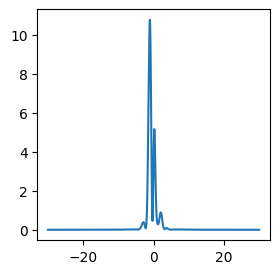

In [786]:
# find tau
xx = jnp.linspace(-30., 30., 1001).reshape((-1, 1))
ss = jax.vmap(trained_kef_model.score)(xx)

# test_kernel = kernels.IMQ(sigma_sq=2*1**2, X=X, Y=X)

poly_weight_fn = kernels.PolyWeightFunction(a=1.)
kernel0 = kernels.IMQ(sigma_sq=2*1.**2)
test_kernel = kernels.TiltedKernel(kernel=kernel0, weight_fn=poly_weight_fn)

ksd = metrics.KSD(test_kernel)
ksd_mat = ksd(xx, xx, score=ss, vstat=True, output_dim=2)
ksd_vals = jnp.diag(ksd_mat)

_, ax = plt.subplots(figsize=(3,3))
_ = plt.plot(xx.reshape(-1), ksd_vals)

tau = jnp.max(ksd_vals[jnp.reshape(jnp.logical_or(xx > 8., xx < -8.), -1)])
tau

In [787]:
# theta_new = 0.01 * test_res["tilted_robust_dev"]["tau"][0]**0.5
theta_new = 0.1 * tau **0.5
test_res_new = copy.deepcopy(test_res)
test_res_new = exp_utils.change_theta(test_res, ["tilted_robust_dev", "tilted_robust_clt", "tilted_robust_boot"], theta_new)

print("standard", test_res["standard"]["rej"])
print("tilted", test_res["tilted"]["rej"])
print("dev", test_res["tilted_robust_dev"]["rej"])
print("boot", test_res["tilted_robust_boot"]["rej"])

standard [0]
tilted [0]
dev [0]
boot [0]


In [788]:
theta_new**2

Array(0.00023337, dtype=float32)

#### use code from Key et al 

In [425]:
from src.kcomp.bootstrapped_tests import (
    Bootstrap,
    parametric_bootstrap_test,
    wild_bootstrap_test,
)

from src.kcomp.distributions.kef import kernel_exp_family
from src.kcomp.kernels import IMQKernel, SumKernel
from src.kcomp.ksd import KSDAnalyticEstimator, KSDStatistic
from src.kcomp.rejection_sampler import LowAcceptanceError

from experiments.efm import sample_outlier_contam

In [346]:
# 1. pure data
X = ys

# 2. contam data
# X = sample_outlier_contam(ys, eps=0.1, ol_mean=5., ol_std=0.1)

In [360]:
rng = jax.random.PRNGKey(seed=56789)

kef_l = jnp.sqrt(2)
kef_q0_std = 3.0

# kernel = SumKernel([IMQKernel(l) for l in [0.6, 1.0, 1.2]])
kernel = IMQKernel(.6)
# test_ps = [1, 2, 3, 4, 5, 25]
L = 25

null = kernel_exp_family(L, kef_l, q0_std=kef_q0_std)
test_stat = KSDStatistic(kernel, null)
estimator = KSDAnalyticEstimator(kernel, null)

rng, rng_input = jax.random.split(rng)
test_result = wild_bootstrap_test(
    rng_input,
    X,
    estimator,
    test_stat,
    n_bootstrap_samples=500,
    save_null_distribution=False,
)

In [361]:
test_result.theta_hat

Array([-1.4936023 ,  0.4768291 ,  5.0071507 , -5.2358356 , -0.13066   ,
       -2.7816918 , -0.6536812 , -1.3812765 , -0.1835363 , -1.0591702 ,
        0.16677836, -1.0724868 ,  0.33188555, -1.0265937 ,  0.2763928 ,
       -0.7605494 , -0.01352196, -0.26332438, -0.4435546 ,  0.3559273 ,
       -0.8376432 ,  0.9226108 , -1.0316159 ,  1.2795163 , -0.95474637],      dtype=float32)

In [362]:
test_result.reject_null

False

In [363]:
# null(test_result.theta_hat)

In [364]:
trained_kef_model = exp_kef.KernelExpFamily(test_result.theta_hat, bw=np.sqrt(2), L=L, p0_loc=0., p0_scale=kef_q0_std)

In [365]:
seed = jax.random.PRNGKey(seed=56789)

X_plot = np.reshape(np.linspace(-10., 10., 1001), (-1, 1))
approx_prob = trained_kef_model.approx_prob(seed, xs=X_plot, n_samples=2000)

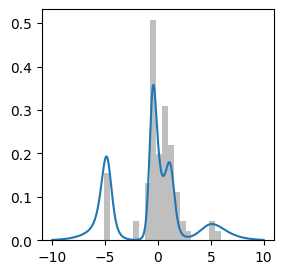

In [366]:
_, ax = plt.subplots(figsize=(3,3))

ax.hist(X.reshape(-1), color="grey", alpha=0.5, bins=20, density=True)
ax.plot(X_plot, approx_prob)

In [329]:
kernel = IMQKernel(1.)
null = kernel_exp_family(L, kef_l, q0_std=kef_q0_std)
estimator = KSDAnalyticEstimator(kernel, null)
estimator(None, X)

big_lambda_n [[ 0.10926925 -0.01898558  0.0572874   0.00991449  0.02270504]
 [-0.01898559  0.01049798 -0.0067044   0.00323491 -0.00144764]
 [ 0.05728738 -0.0067044   0.03412957  0.0090801   0.01507667]
 [ 0.00991448  0.00323491  0.0090801   0.00553043  0.00515309]
 [ 0.02270505 -0.00144764  0.01507668  0.00515309  0.00725382]]
nu_n [-0.04348493  0.04131965 -0.00364204  0.02598427  0.00794143]
eta_estimate [-0.92201036  0.47297215  3.8515208  -5.9567223  -1.3223526 ]
theta_estimate [-0.92201036  0.47297215  3.8515208  -5.9567223  -1.3223526 ]


Array([-0.92201036,  0.47297215,  3.8515208 , -5.9567223 , -1.3223526 ],      dtype=float32)

In [337]:
kernel = kernels.IMQ(sigma_sq=2*1.**2)
est_params = kef.ksd_est(X, kernel)

In [338]:
est_params

Array([-0.9219946,  0.4730076,  3.8514888, -5.956779 , -1.3222908],      dtype=float32)

# Synthetic data

In [211]:
# def sample_from_mixture(n):
#     means = [-5., 0., 5.]
#     stds = [0.1, .5, 0.1]
#     ratios = [0.1, 0.85, 0.05]
#     ns = np.random.multinomial(n, ratios, size=1).astype(np.int64)
#     X_ls = []
#     for i in range(len(means)):
#         X_ls.append(np.random.normal(loc=np.array(means[i]), scale=np.array(stds[i]), size=(ns[0][i], 1)))

#     X = np.concatenate(X_ls, 0)
#     return jnp.array(X)

In [93]:
np.random.seed(321)

add_outlier = True
n = 100
ntest = 100

# 1. pure data
X = exp_kef.sample_from_mixture(n)

# # remove "outliers"
# X = X[X < 2.5]
# X = np.reshape(X[X > -2.5], (-1, 1))

# # 2. contam data
if add_outlier:
    eps = 0.1
    ol_mean = 10.
    X = exp_efm.sample_outlier_contam(X, eps=eps, ol_mean=ol_mean, ol_std=0.1)

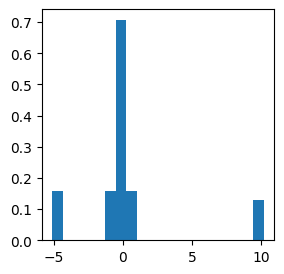

In [94]:
_, ax = plt.subplots(figsize=(3, 3))

_ = ax.hist(jnp.squeeze(X), bins=20, density=True)

In [95]:
L = 25
kef_l = jnp.sqrt(2)
kef_p0_std = 3.
params = None # np.ones((L,))
kef = exp_kef.KernelExpFamily(params=params, bw=kef_l, L=L, p0_loc=0., p0_scale=kef_p0_std)

In [96]:
# kernel = kernels.SumKernel([kernels.IMQ(sigma_sq=2*l**2) for l in [0.6, 1.0, 1.2]])
# kernel = kernels.IMQ(med_heuristic=True, X=X, Y=X)
# kernel = kernels.IMQ(sigma_sq=2*1.**2, X=X, Y=X)

# poly_weight_fn = kernels.PolyWeightFunction(a=X.std())
poly_weight_fn = kernels.PolyWeightFunction(a=1.)
kernel0 = kernels.IMQ(sigma_sq=2*1.**2, X=X, Y=X)
kernel = kernels.TiltedKernel(kernel=kernel0, weight_fn=poly_weight_fn)

est_params = kef.ksd_est(X, kernel)
print("est_params", est_params)

est_params [-9.0231603e-01 -5.7383990e+00  7.8100693e-01 -1.4161769e+00
  2.3211999e-01 -2.4199693e-01  5.8003921e-02 -5.3495731e-02
  4.3157447e-02 -5.7300705e-02  7.6365426e-02 -1.0099503e-01
  1.2820484e-01 -1.5612707e-01  1.8231705e-01 -2.0421004e-01
  2.1928085e-01 -2.2539443e-01  2.2102806e-01 -2.0552942e-01
  1.7918788e-01 -1.4324996e-01  9.9751756e-02 -5.1325954e-02
  9.0811145e-04]


In [97]:
trained_kef_model = exp_kef.KernelExpFamily(est_params, bw=kef_l, L=L, p0_loc=0., p0_scale=kef_p0_std)

In [98]:
seed = jax.random.PRNGKey(seed=56789)
X_plot = np.reshape(np.linspace(-10., 10., 1001), (-1, 1))
approx_prob = trained_kef_model.approx_prob(seed, xs=X_plot, n_samples=2000)

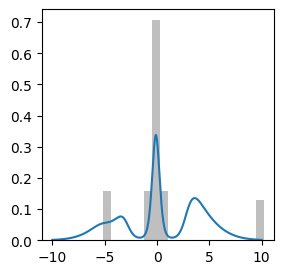

In [99]:
_, ax = plt.subplots(figsize=(3,3))
ax.hist(X.reshape(-1), color="grey", alpha=0.5, bins=20, density=True)
ax.plot(X_plot, approx_prob)

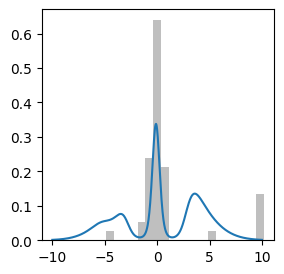

In [100]:
# # generate independent sample for testing
X_test = exp_kef.sample_from_mixture(ntest)
# X_test = sample_from_mixture(500)

if add_outlier:
    X_test = exp_efm.sample_outlier_contam(X_test, eps=eps, ol_mean=ol_mean, ol_std=0.1)

_, ax = plt.subplots(figsize=(3,3))
ax.hist(X_test.reshape(-1), color="grey", alpha=0.5, bins=20, density=True)
ax.plot(X_plot, approx_prob)

In [101]:
# # test 
# score = jax.vmap(trained_kef_model.score)(X_test)

# # test_kernel = kernel
# # test_kernel = kernels.IMQ(sigma_sq=2*1.**2, X=X, Y=X)

# poly_weight_fn = kernels.PolyWeightFunction(a=X.std())
# poly_weight_fn = kernels.PolyWeightFunction(a=X.std())
# kernel0 = kernels.IMQ(sigma_sq=2*1.**2)
# test_kernel = kernels.TiltedKernel(kernel=kernel0, weight_fn=poly_weight_fn)


# ksd = metrics.KSD(test_kernel)
# wild_boot = boot.WildBootstrap(ksd)
# pval, stat, boot_stats = wild_boot.pval(X_test, X_test, return_stat=True, return_boot=True, score=score, hvp=None)
# pval

In [102]:
# test 
score = jax.vmap(trained_kef_model.score)(X_test)

# weight_fn_args = {"a": X_test.std()}
weight_fn_args = None
theta = 0.1

X_test_b = jnp.reshape(X_test, (1, -1, 1))
score_b = jnp.reshape(score, (1, -1, 1))
test_res = exp_utils.run_tests(
    samples=X_test_b, scores=score_b, hvps=None, hvp_denom_sup=None, 
    theta=theta, bw=2.*1**2, alpha=0.05, verbose=True, base_kernel="IMQ", weight_fn_args=weight_fn_args,
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.01it/s]


In [103]:
test_res["tilted"]["pval"]

[Array(0.32667333, dtype=float32, weak_type=True)]

In [104]:
print("standard", test_res["standard"]["rej"])
print("tilted", test_res["tilted"]["rej"])
print("dev", test_res["tilted_robust_dev"]["rej"])
print("boot", test_res["tilted_robust_boot"]["rej"])

standard [0]
tilted [0]
dev [0]
boot [0]


In [59]:
print("stat", test_res["tilted_robust_boot"]["stat"])
print("threshold", test_res["tilted_robust_boot"]["threshold"])

stat [Array(0.15768242, dtype=float32)]
threshold [0.35415090382099124]


In [60]:
theta_new = 0.00001**0.5
test_res_new = copy.deepcopy(test_res)
test_res_new = exp_utils.change_theta(test_res, ["tilted_robust_dev", "tilted_robust_clt", "tilted_robust_boot"], theta_new)

In [61]:
print("dev", test_res_new["tilted_robust_dev"]["rej"])
print("boot", test_res_new["tilted_robust_boot"]["rej"])

dev [0]
boot [0]


In [75]:
tau = test_res["tilted_robust_dev"]["tau"][0]
0.01 * tau**0.5

Array(0.09433305, dtype=float32)

In [579]:
ksd = test_res["tilted_robust_dev"]["ksd_class"][0]

In [586]:
xx = jnp.array([[w] for w in [0., 1., 10., 30.]])
ss = jax.vmap(trained_kef_model.score)(xx)
ksd(xx, xx, score=ss, output_dim=2, vstat=True)

Array([[ 1.1577858e+00, -2.4974749e+00, -1.8066440e-20,  0.0000000e+00],
       [-2.4974749e+00,  8.0888834e+00, -1.3248710e-16,  0.0000000e+00],
       [-1.8066440e-20, -1.3248707e-16,  1.5360247e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  2.2207808e+00]],      dtype=float32)

# load test results

#### galaxy

In [224]:
stats_res = pickle.load(open("../data/kef/kef_galaxy_level_stats_seed2024.pkl", "rb"))
eps_ls = list(stats_res.keys())
ol_means_ls = list(stats_res[eps_ls[0]].keys())

In [225]:
X_res = pickle.load(open("../data/kef/kef_galaxy_level_X_res_seed2024.pkl", "rb"))
est_params_res = pickle.load(open("../data/kef/kef_galaxy_level_est_params_res_seed2024.pkl", "rb"))

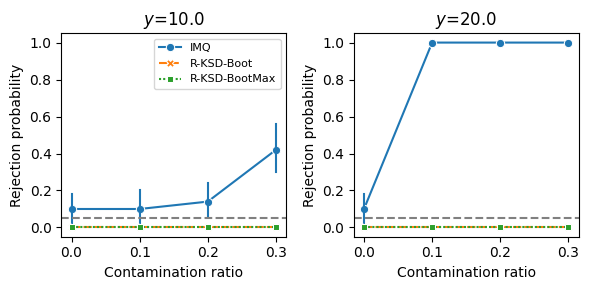

In [226]:
res_plot = stats_res
methods = {"standard": "IMQ", "tilted": "Tilted", "tilted_r_boot": "R-KSD-Boot", "tilted_r_bootmax": "R-KSD-BootMax"}

plot_df = {"eps": [], "ol": [], "nonsq_stat": [], "nonsq_u_stat": [], "method": [], "rej": []}
for eps in eps_ls:
    for ol in ol_means_ls:
        rr = res_plot[eps][ol]["tilted"]["nonsq_stat"]
        for m, m_label in methods.items():
            plot_df["nonsq_stat"] = plot_df["nonsq_stat"] + np.array(rr).tolist()
            plot_df["nonsq_u_stat"] = plot_df["nonsq_u_stat"] + (np.array(rr)**0.5).tolist()
            plot_df["eps"] = plot_df["eps"] + [eps] * len(rr)
            plot_df["ol"] = plot_df["ol"] + [ol] * len(rr)
            
            plot_df["rej"] = plot_df["rej"] + res_plot[eps][ol][m]["rej"]
            plot_df["method"] = plot_df["method"] + [m_label] * len(rr)

plot_df = pd.DataFrame(plot_df)

_, axes = plt.subplots(ncols=len(ol_means_ls), figsize=(3*len(ol_means_ls), 3))
for i, ol in enumerate(ol_means_ls):
    ax = axes.flatten()[i] if len(ol_means_ls) > 1 else axes
    subplot_df = plot_df.loc[plot_df.ol == ol]
    
    _ = sns.lineplot(ax=ax, data=subplot_df, x="eps", y="rej", hue="method", style="method", markers=True, err_style="bars")
    ax.set_title(rf"$y$={ol}")
    ax.set_ylim(-0.05, 1.05)
    ax.axhline(0.05, color="grey", linestyle="--")
    ax.legend([],[], frameon=False)
    ax.set_ylabel("Rejection probability")
    ax.set_xlabel("Contamination ratio")

# ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
axes[0].legend(fontsize=8)
# ax.legend()
plt.tight_layout()
# plt.savefig("../figs/robust/kef_level_rej.pdf")

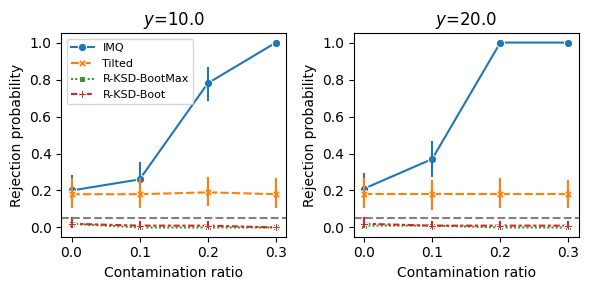

In [59]:
res_plot = stats_res
methods = {"standard": "IMQ", "tilted": "Tilted", "tilted_robust_boot": "R-KSD-BootMax", "tilted_robust_degenboot": "R-KSD-Boot"}

plot_df = {"eps": [], "ol": [], "nonsq_stat": [], "nonsq_u_stat": [], "method": [], "rej": []}
for eps in eps_ls:
    for ol in ol_means_ls:
        rr = res_plot[eps][ol]["tilted"]["nonsq_stat"]
        for m, m_label in methods.items():
            plot_df["nonsq_stat"] = plot_df["nonsq_stat"] + np.array(rr).tolist()
            plot_df["nonsq_u_stat"] = plot_df["nonsq_u_stat"] + (np.array(rr)**0.5).tolist()
            plot_df["eps"] = plot_df["eps"] + [eps] * len(rr)
            plot_df["ol"] = plot_df["ol"] + [ol] * len(rr)
            
            plot_df["rej"] = plot_df["rej"] + res_plot[eps][ol][m]["rej"]
            plot_df["method"] = plot_df["method"] + [m_label] * len(rr)

plot_df = pd.DataFrame(plot_df)

_, axes = plt.subplots(ncols=len(ol_means_ls), figsize=(3*len(ol_means_ls), 3))
for i, ol in enumerate(ol_means_ls):
    ax = axes.flatten()[i] if len(ol_means_ls) > 1 else axes
    subplot_df = plot_df.loc[plot_df.ol == ol]
    
    _ = sns.lineplot(ax=ax, data=subplot_df, x="eps", y="rej", hue="method", style="method", markers=True, err_style="bars")
    ax.set_title(rf"$y$={ol}")
    ax.set_ylim(-0.05, 1.05)
    ax.axhline(0.05, color="grey", linestyle="--")
    ax.legend([],[], frameon=False)
    ax.set_ylabel("Rejection probability")
    ax.set_xlabel("Contamination ratio")

# ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
axes[0].legend(fontsize=8)
# ax.legend()
plt.tight_layout()
# plt.savefig("../figs/robust/kef_level_rej.pdf")

In [22]:
X_res[eps_ls[0]][ol][0].reshape(-1)

Array([ 0.84563303,  0.38485888, -0.27874407, -0.42866102, -0.77523375,
       -0.65485924,  0.846074  ,  0.43468422, -0.66059136, -4.969381  ,
       -0.5137609 , -0.43307033, -4.5954704 ,  0.62648976, -0.59753805,
       -0.65221363,  1.0735949 , -1.0622807 , -5.002451  ,  1.5599432 ,
        0.48186398,  1.5242277 ,  0.49906033,  0.29270405,  1.2689279 ,
       -0.83828706,  0.13617313, -0.27036637, -0.56755465,  0.06959236,
        1.8350849 ,  2.719154  , -5.0610948 , -0.08782043,  0.73495907,
        1.2512907 ,  0.59827006,  1.2711326 ,  0.6234032 ,  1.171041  ,
        5.2739153 ], dtype=float32)

In [23]:
X_res[eps_ls[0]][ol][10].reshape(-1)

Array([-0.5137609 ,  2.5846696 , -0.4255745 ,  1.171041  , -0.29197204,
        0.00786186, -0.28800365,  0.84563303, -5.0610948 , -0.5728459 ,
        0.13617313,  0.43468422,  2.1186044 ,  0.846074  ,  1.2711326 ,
       -0.59753805,  0.49906033,  0.59827006,  0.62648976,  1.0638945 ,
        5.2739153 , -0.43307033,  1.7147104 , -0.83828706, -5.1395807 ,
        1.4554423 , -0.01462569,  2.719154  ,  1.5599432 , -1.0036366 ,
        0.06959236, -4.8736987 , -0.65485924, -0.08782043,  1.1966151 ,
       -0.5649091 , -0.27874407, -4.969381  , -0.18217993,  5.930904  ,
       -0.40132323], dtype=float32)

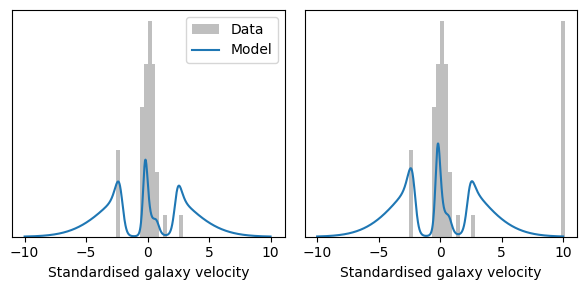

In [222]:
_, axes = plt.subplots(ncols=2, figsize=(3*2, 3))

# plot data
ol = 10.
eps_ls = [0., 0.2]
idx = 0
bins = np.histogram(np.hstack(
    (X_res[eps_ls[0]][ol][idx].reshape(-1), X_res[eps_ls[1]][ol][idx].reshape(-1))
), bins=40)[1]

for i, eps in enumerate(eps_ls):
    est_params = est_params_res[eps][ol][0]
    # L = 25
    # kef_l = jnp.sqrt(2)
    # kef_p0_std = 3.

    L = 25 #!
    kef_l = jnp.sqrt(.5) #!
    kef_p0_std = 3. #!
    
    trained_kef_model = exp_kef.KernelExpFamily(est_params, bw=kef_l, L=L, p0_loc=0., p0_scale=kef_p0_std)
    X_plot = np.reshape(np.linspace(-10., 10., 1001), (-1, 1))
    approx_prob = trained_kef_model.approx_prob(jax.random.PRNGKey(seed=56789), xs=X_plot, n_samples=2000)

    ax = axes[i]
    ax.hist(X_res[eps][ol][0].reshape(-1), bins, color="grey", alpha=0.5, density=True, label="Data")
    ax.plot(X_plot, approx_prob, label="Model")
    ax.get_yaxis().set_visible(False)
    ax.set_xlabel("Standardised galaxy velocity")

axes[0].legend()
plt.tight_layout()
# plt.savefig("../figs/robust/kef_level_data.pdf")

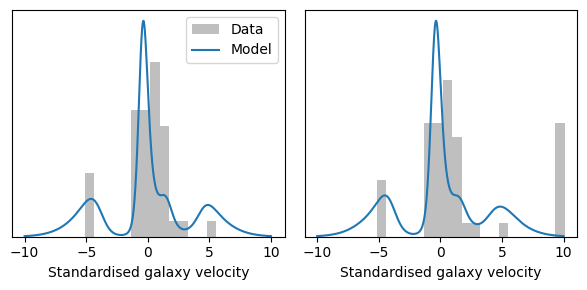

In [21]:
_, axes = plt.subplots(ncols=2, figsize=(3*2, 3))

# plot data
ol = 10.
eps_ls = [0., 0.2]
idx = 10
bins = np.histogram(np.hstack(
    (X_res[eps_ls[0]][ol][idx].reshape(-1), X_res[eps_ls[1]][ol][idx].reshape(-1))
), bins=20)[1]

for i, eps in enumerate(eps_ls):
    est_params = est_params_res[eps][ol][0]
    L = 25
    kef_l = jnp.sqrt(2)
    kef_p0_std = 3.
    
    trained_kef_model = exp_kef.KernelExpFamily(est_params, bw=kef_l, L=L, p0_loc=0., p0_scale=kef_p0_std)
    X_plot = np.reshape(np.linspace(-10., 10., 1001), (-1, 1))
    approx_prob = trained_kef_model.approx_prob(jax.random.PRNGKey(seed=56789), xs=X_plot, n_samples=2000)

    ax = axes[i]
    ax.hist(X_res[eps][ol][0].reshape(-1), bins, color="grey", alpha=0.5, density=True, label="Data")
    ax.plot(X_plot, approx_prob, label="Model")
    ax.get_yaxis().set_visible(False)
    ax.set_xlabel("Standardised galaxy velocity")

axes[0].legend()
plt.tight_layout()
# plt.savefig("../figs/robust/kef_level_data.pdf")

In [233]:
print("theta", stats_res[0.][10.]["tilted_r_boot"]["theta"][0])

In [230]:
stats_res = pickle.load(open("../data/kef/kef_galaxy_power_stats_seed2024.pkl", "rb"))
eps_ls = list(stats_res.keys())
ol_means_ls = list(stats_res[eps_ls[0]].keys())

X_res = pickle.load(open("../data/kef/kef_galaxy_power_X_res_seed2024.pkl", "rb"))
est_params_res = pickle.load(open("../data/kef/kef_galaxy_power_est_params_res_seed2024.pkl", "rb"))

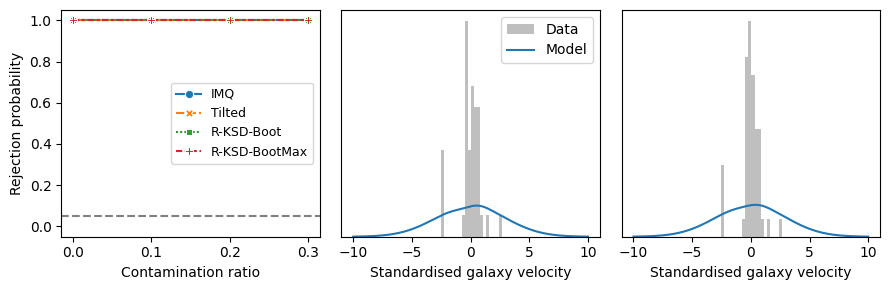

In [231]:
_, axes = plt.subplots(ncols=3, figsize=(9, 3))

res_plot = stats_res
methods = {"standard": "IMQ", "tilted": "Tilted", "tilted_r_boot": "R-KSD-Boot", "tilted_r_bootmax": "R-KSD-BootMax"}

ol = 0.
plot_df = {"eps": [], "ol": [], "nonsq_stat": [], "nonsq_u_stat": [], "method": [], "rej": []}
for eps in eps_ls:
    rr = res_plot[eps][ol]["tilted"]["nonsq_stat"]
    for m, m_label in methods.items():
        plot_df["nonsq_stat"] = plot_df["nonsq_stat"] + np.array(rr).tolist()
        plot_df["nonsq_u_stat"] = plot_df["nonsq_u_stat"] + (np.array(rr)**0.5).tolist()
        plot_df["eps"] = plot_df["eps"] + [eps] * len(rr)
        plot_df["ol"] = plot_df["ol"] + [ol] * len(rr)
        
        plot_df["rej"] = plot_df["rej"] + res_plot[eps][ol][m]["rej"]
        plot_df["method"] = plot_df["method"] + [m_label] * len(rr)

plot_df = pd.DataFrame(plot_df)

eps = eps_ls[i]
subplot_df = plot_df.loc[plot_df.ol == ol]

ax = axes[0]
_ = sns.lineplot(ax=ax, data=subplot_df, x="eps", y="rej", hue="method", style="method", markers=True, err_style="bars")
ax.set_ylim(-0.05, 1.05)
ax.axhline(0.05, color="grey", linestyle="--")
ax.set_ylabel("Rejection probability")
ax.set_xlabel("Contamination ratio")
ax.legend([],[], frameon=False)

ax.legend(fontsize=9)

# 2. plot data
ol = 0.
eps_ls = [0., 0.2]
bins = np.histogram(np.hstack(
    (X_res[eps_ls[0]][ol][0].reshape(-1), X_res[eps_ls[1]][ol][0].reshape(-1))
), bins=20)[1]

for i, eps in enumerate(eps_ls):
    est_params = est_params_res[eps][ol][0]
    L = 1
    kef_l = jnp.sqrt(2)
    kef_p0_std = 3.
    
    trained_kef_model = exp_kef.KernelExpFamily(est_params, bw=kef_l, L=L, p0_loc=0., p0_scale=kef_p0_std)
    X_plot = np.reshape(np.linspace(-10., 10., 1001), (-1, 1))
    approx_prob = trained_kef_model.approx_prob(jax.random.PRNGKey(seed=56789), xs=X_plot, n_samples=2000)
    
    ax = axes[i+1]
    ax.hist(X_res[eps][ol][0].reshape(-1), bins, color="grey", alpha=0.5, density=True, label="Data")
    ax.plot(X_plot, approx_prob, label="Model")
    ax.get_yaxis().set_visible(False)
    ax.set_xlabel("Standardised galaxy velocity")
    
axes[1].legend()
plt.tight_layout()
# plt.savefig("../figs/robust/kef_power_rej.pdf")

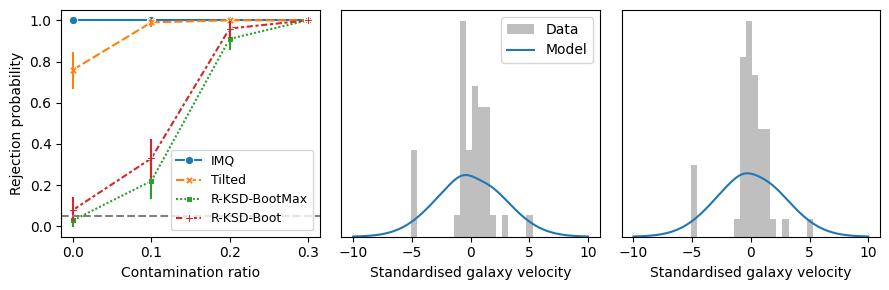

In [72]:
_, axes = plt.subplots(ncols=3, figsize=(9, 3))

res_plot = stats_res
methods = {"standard": "IMQ", "tilted": "Tilted", "tilted_r_boot": "R-KSD-Boot", "tilted_r_bootmax": "R-KSD-BootMax"}

ol = 0.
plot_df = {"eps": [], "ol": [], "nonsq_stat": [], "nonsq_u_stat": [], "method": [], "rej": []}
for eps in eps_ls:
    rr = res_plot[eps][ol]["tilted"]["nonsq_stat"]
    for m, m_label in methods.items():
        plot_df["nonsq_stat"] = plot_df["nonsq_stat"] + np.array(rr).tolist()
        plot_df["nonsq_u_stat"] = plot_df["nonsq_u_stat"] + (np.array(rr)**0.5).tolist()
        plot_df["eps"] = plot_df["eps"] + [eps] * len(rr)
        plot_df["ol"] = plot_df["ol"] + [ol] * len(rr)
        
        plot_df["rej"] = plot_df["rej"] + res_plot[eps][ol][m]["rej"]
        plot_df["method"] = plot_df["method"] + [m_label] * len(rr)

plot_df = pd.DataFrame(plot_df)

eps = eps_ls[i]
subplot_df = plot_df.loc[plot_df.ol == ol]

ax = axes[0]
_ = sns.lineplot(ax=ax, data=subplot_df, x="eps", y="rej", hue="method", style="method", markers=True, err_style="bars")
ax.set_ylim(-0.05, 1.05)
ax.axhline(0.05, color="grey", linestyle="--")
ax.set_ylabel("Rejection probability")
ax.set_xlabel("Contamination ratio")
ax.legend([],[], frameon=False)

# ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.legend(fontsize=9)

# 2. plot data
ol = 0.
eps_ls = [0., 0.2]
bins = np.histogram(np.hstack(
    (X_res[eps_ls[0]][ol][0].reshape(-1), X_res[eps_ls[1]][ol][0].reshape(-1))
), bins=20)[1]

for i, eps in enumerate(eps_ls):
    est_params = est_params_res[eps][ol][0]
    L = 1
    kef_l = jnp.sqrt(2)
    kef_p0_std = 3.
    
    trained_kef_model = exp_kef.KernelExpFamily(est_params, bw=kef_l, L=L, p0_loc=0., p0_scale=kef_p0_std)
    X_plot = np.reshape(np.linspace(-10., 10., 1001), (-1, 1))
    approx_prob = trained_kef_model.approx_prob(jax.random.PRNGKey(seed=56789), xs=X_plot, n_samples=2000)
    
    ax = axes[i+1]
    ax.hist(X_res[eps][ol][0].reshape(-1), bins, color="grey", alpha=0.5, density=True, label="Data")
    ax.plot(X_plot, approx_prob, label="Model")
    ax.get_yaxis().set_visible(False)
    ax.set_xlabel("Standardised galaxy velocity")
    
axes[1].legend()
plt.tight_layout()
# plt.savefig("../figs/robust/kef_power_rej.pdf")

In [39]:
print("theta", stats_res[0.][0.]["tilted_robust_dev"]["theta"][0])

theta 0.07748335


#### synthetic

In [15]:
stats_res = pickle.load(open("../data/kef/kef_stats_seed2024.pkl", "rb"))
eps_ls = list(stats_res.keys())
ol_means_ls = list(stats_res[eps_ls[0]].keys())

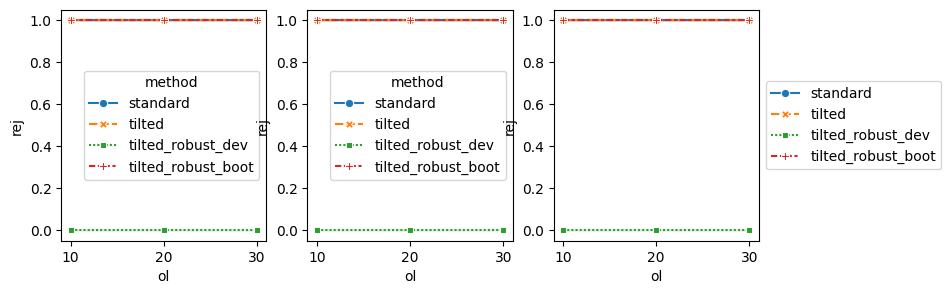

In [19]:
_, axes = plt.subplots(ncols=len(eps_ls), figsize=(3*len(eps_ls), 3))

res_plot = stats_res
method_list = ["standard", "tilted", "tilted_robust_dev", "tilted_robust_boot"]

plot_df = {"eps": [], "ol": [], "nonsq_stat": [], "nonsq_u_stat": [], "method": [], "rej": []}
for eps in eps_ls:
    for ol in ol_means_ls:
        rr = res_plot[eps][ol]["tilted"]["nonsq_stat"]
        for m in method_list:
            plot_df["nonsq_stat"] = plot_df["nonsq_stat"] + np.array(rr).tolist()
            plot_df["nonsq_u_stat"] = plot_df["nonsq_u_stat"] + (np.array(rr)**0.5).tolist()
            plot_df["eps"] = plot_df["eps"] + [eps] * len(rr)
            plot_df["ol"] = plot_df["ol"] + [ol] * len(rr)
            
            plot_df["rej"] = plot_df["rej"] + res_plot[eps][ol][m]["rej"]
            plot_df["method"] = plot_df["method"] + [m] * len(rr)

plot_df = pd.DataFrame(plot_df)

for i, ax in enumerate(axes.flatten()):
    subplot_df = plot_df.loc[plot_df.eps == eps_ls[i]]
    
    _ = sns.lineplot(ax=ax, data=subplot_df, x="ol", y="rej", hue="method", style="method", markers=True)

ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

#### visualise weighting function

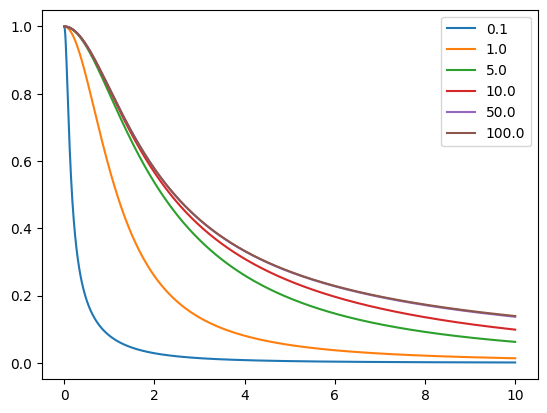

In [196]:
# weighting function
x_kernel = np.linspace(-0, 10., 1001).reshape((-1, 1))

for a in [0.1, 1., 5., 10., 50., 100.]:
    poly_weight_fn = kernels.PolyWeightFunction(a=a)
    kernel0 = kernels.IMQ(sigma_sq=2*1.**2, X=x_kernel, Y=x_kernel)
    kernel = kernels.TiltedKernel(kernel=kernel0, weight_fn=poly_weight_fn)
    
    kk_mat = kernel(x_kernel, x_kernel)
    
    _ = plt.plot(x_kernel[:, 0], kk_mat[0], label=a)

_ = plt.legend()